In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!unzip "/content/drive/MyDrive/DeepDetect/celebDF.zip" -d "/content/data/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/data/Celeb_V2/Val/real/00007_face_431.jpg  
  inflating: /content/data/Celeb_V2/Val/real/00007_face_432.jpg  
  inflating: /content/data/Celeb_V2/Val/real/00007_face_433.jpg  
  inflating: /content/data/Celeb_V2/Val/real/00007_face_434.jpg  
  inflating: /content/data/Celeb_V2/Val/real/00007_face_443.jpg  
  inflating: /content/data/Celeb_V2/Val/real/00008_face_481.jpg  
  inflating: /content/data/Celeb_V2/Val/real/00008_face_512.jpg  
  inflating: /content/data/Celeb_V2/Val/real/00009_face_516.jpg  
  inflating: /content/data/Celeb_V2/Val/real/00009_face_517.jpg  
  inflating: /content/data/Celeb_V2/Val/real/00009_face_528.jpg  
  inflating: /content/data/Celeb_V2/Val/real/00009_face_530.jpg  
  inflating: /content/data/Celeb_V2/Val/real/00009_face_532.jpg  
  inflating: /content/data/Celeb_V2/Val/real/00009_face_535.jpg  
  inflating: /content/data/Celeb_V2/Val/real/00009_face_545.jpg  
  inflating: /content/dat

In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [5]:
class DeepfakeDataset(Dataset):
    def __init__(self, data_dir, split, transform=None):
        """
        Args:
            data_dir: base folder (with Train, Val, Test)
            split: 'Train', 'Val', 'Test'
        """
        self.data_dir = os.path.join(data_dir, split)
        self.transform = transform
        self.images = []
        self.labels = []
        self.label_map = {"real": 0, "fake": 1}

        for label in ["real", "fake"]:
            folder = os.path.join(self.data_dir, label)
            if not os.path.exists(folder):
                continue
            for img_name in os.listdir(folder):
                if img_name.lower().endswith((".jpg", ".png", ".jpeg")):
                    self.images.append(os.path.join(folder, img_name))
                    self.labels.append(self.label_map[label])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]

        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, label

In [6]:
input_size = 224
batch_size = 32

transform = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

In [7]:
data_dir = "/content/data/Celeb_V2"

In [8]:
train_dataset = DeepfakeDataset(data_dir, "Train", transform=transform)
val_dataset   = DeepfakeDataset(data_dir, "Val", transform=transform)
test_dataset  = DeepfakeDataset(data_dir, "Test", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}, Test samples: {len(test_dataset)}")


Train samples: 80824, Val samples: 10104, Test samples: 10103


In [9]:
# Model (Pretrained ResNet18)

model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, 2)  # binary classification
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 208MB/s]


In [10]:
# Training Function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device):
    best_val_acc = 0.0

    for epoch in range(num_epochs):
        # Train
        model.train()
        train_loss, train_correct, train_total = 0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        train_loss /= train_total
        train_acc = 100 * train_correct / train_total

        # Validate
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss /= val_total
        val_acc = 100 * val_correct / val_total

        scheduler.step()

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_deepfake_model.pth")

        print(f"Epoch {epoch+1}/{num_epochs}: "
              f"Train Loss {train_loss:.4f}, Acc {train_acc:.2f}% | "
              f"Val Loss {val_loss:.4f}, Acc {val_acc:.2f}%")

    print("Best Val Accuracy:", best_val_acc)

In [11]:
# Run Training
num_epochs = 10
train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device)


Epoch 1/10: Train Loss 0.0972, Acc 96.05% | Val Loss 0.1504, Acc 94.37%
Epoch 2/10: Train Loss 0.0307, Acc 98.89% | Val Loss 0.0449, Acc 98.40%
Epoch 3/10: Train Loss 0.0220, Acc 99.18% | Val Loss 0.0310, Acc 98.97%
Epoch 4/10: Train Loss 0.0170, Acc 99.41% | Val Loss 0.0251, Acc 99.13%
Epoch 5/10: Train Loss 0.0135, Acc 99.55% | Val Loss 0.0283, Acc 98.99%
Epoch 6/10: Train Loss 0.0033, Acc 99.89% | Val Loss 0.0110, Acc 99.60%
Epoch 7/10: Train Loss 0.0011, Acc 99.96% | Val Loss 0.0130, Acc 99.58%
Epoch 8/10: Train Loss 0.0009, Acc 99.96% | Val Loss 0.0101, Acc 99.68%
Epoch 9/10: Train Loss 0.0008, Acc 99.96% | Val Loss 0.0138, Acc 99.59%
Epoch 10/10: Train Loss 0.0006, Acc 99.97% | Val Loss 0.0124, Acc 99.70%
Best Val Accuracy: 99.70308788598575


In [12]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load best model
model.load_state_dict(torch.load("best_deepfake_model.pth", map_location=device))
model.eval()

all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())


# 1. Metrics

print("Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=["Real", "Fake"]))



Classification Report:

              precision    recall  f1-score   support

        Real       1.00      1.00      1.00      5036
        Fake       1.00      1.00      1.00      5067

    accuracy                           1.00     10103
   macro avg       1.00      1.00      1.00     10103
weighted avg       1.00      1.00      1.00     10103



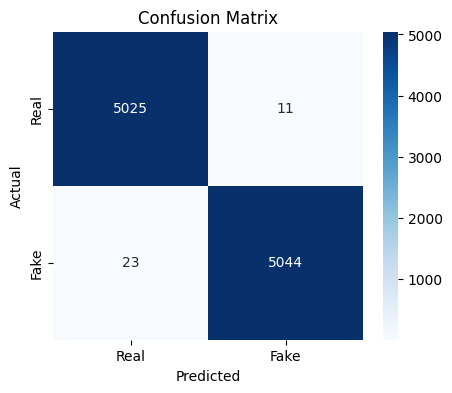

In [13]:
# 2. Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [15]:
def predict_image(model, image_path, transform, device):
    model.eval()
    img = Image.open(image_path).convert("RGB")
    img_t = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img_t)
        _, pred = torch.max(output, 1)

    label = "Real" if pred.item() == 0 else "Fake"
    return label

# Example:

test_img = "/content/data/Celeb_V2/Test/real/00000_face_14.jpg"
result = predict_image(model, test_img, transform, device)
print(f"Prediction: {result}")


Prediction: Real


In [16]:
from google.colab import files
files.download("best_deepfake_model.pth")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
files.download("deepfake_model.pkl")

In [ ]:
# from PIL import Image
# import numpy as np

# # Generate a fake "image" (random RGB values) for testing
# fake_image_array = np.random.randint(0, 256, (128, 128, 3), dtype=np.uint8)
# fake_image = Image.fromarray(fake_image_array)
# fake_image_path = "fake_test_image.jpg"
# fake_image.save(fake_image_path)

# print(f"Fake image saved at: {fake_image_path}")
# display(fake_image)


In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()  # set model to evaluation mode


In [ ]:
from torchvision import transforms
from PIL import Image

transform = transforms.Compose([
    transforms.Resize((128, 128)),  # match training input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


In [ ]:
def predict_image(model, image_path, device):
    # Load image
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)  # add batch dim & move to same device

    # Forward pass
    with torch.no_grad():
        output = model(image)
        _, pred = torch.max(output, 1)

    # Map label
    label_map = {0: "real", 1: "fake"}
    return label_map[pred.item()]


In [ ]:
image_path = "20231129_115339.jpg"  # replace with your actual image
result = predict_image(model, image_path, device)
print("Predicted label:", result)
